Select 10 random items that have 25 data points in the prediction window

In [72]:
epoch_test_start = 2839
epoch_test_end = 2879
target_date = pd.to_datetime("2024-06-02")
epoch_test_ly = 2786

## combine the lightgb and prophet files

In [59]:
#----------------------------------------------------------------
# Load the CSV files into DataFrames
data_file = "/home/py/data/LGBM_ONLINE_v1/data/processed/predictions.csv"
df_lightgbm = pd.read_csv(data_file)

data_file = "/home/py/data/LGBM_ONLINE_v1/data/processed/prophet_predictions.csv"
df_prophet = pd.read_csv(data_file)

# Make sure the date columns are in the correct datetime format
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_lightgbm['date'] = pd.to_datetime(df_lightgbm['date'])

# Rename the 'ds' column in df_prophet to 'date' to match df_lightgbm
df_prophet.rename(columns={'ds': 'date'}, inplace=True)

# Merge the DataFrames
df_merged = pd.merge(df_lightgbm, df_prophet, on=['item_id', 'date'], how='left')

# Save the merged DataFrame to a new CSV file
data_file = "/home/py/data/LGBM_ONLINE_v1/data/processed/merged.csv"
df_merged.to_csv(data_file, index=False)

In [60]:
unique_time_ids = df_prophet['item_id'].nunique()

print("Number of unique prophet time_id values:", unique_time_ids)

unique_time_ids = df_lightgbm['item_id'].nunique()

print("Number of unique lgbm time_id values:", unique_time_ids)

unique_time_ids = df_merged['item_id'].nunique()

print("Number of unique merged time_id values:", unique_time_ids)

Number of unique prophet time_id values: 5080
Number of unique lgbm time_id values: 5080
Number of unique merged time_id values: 5080


## Random items

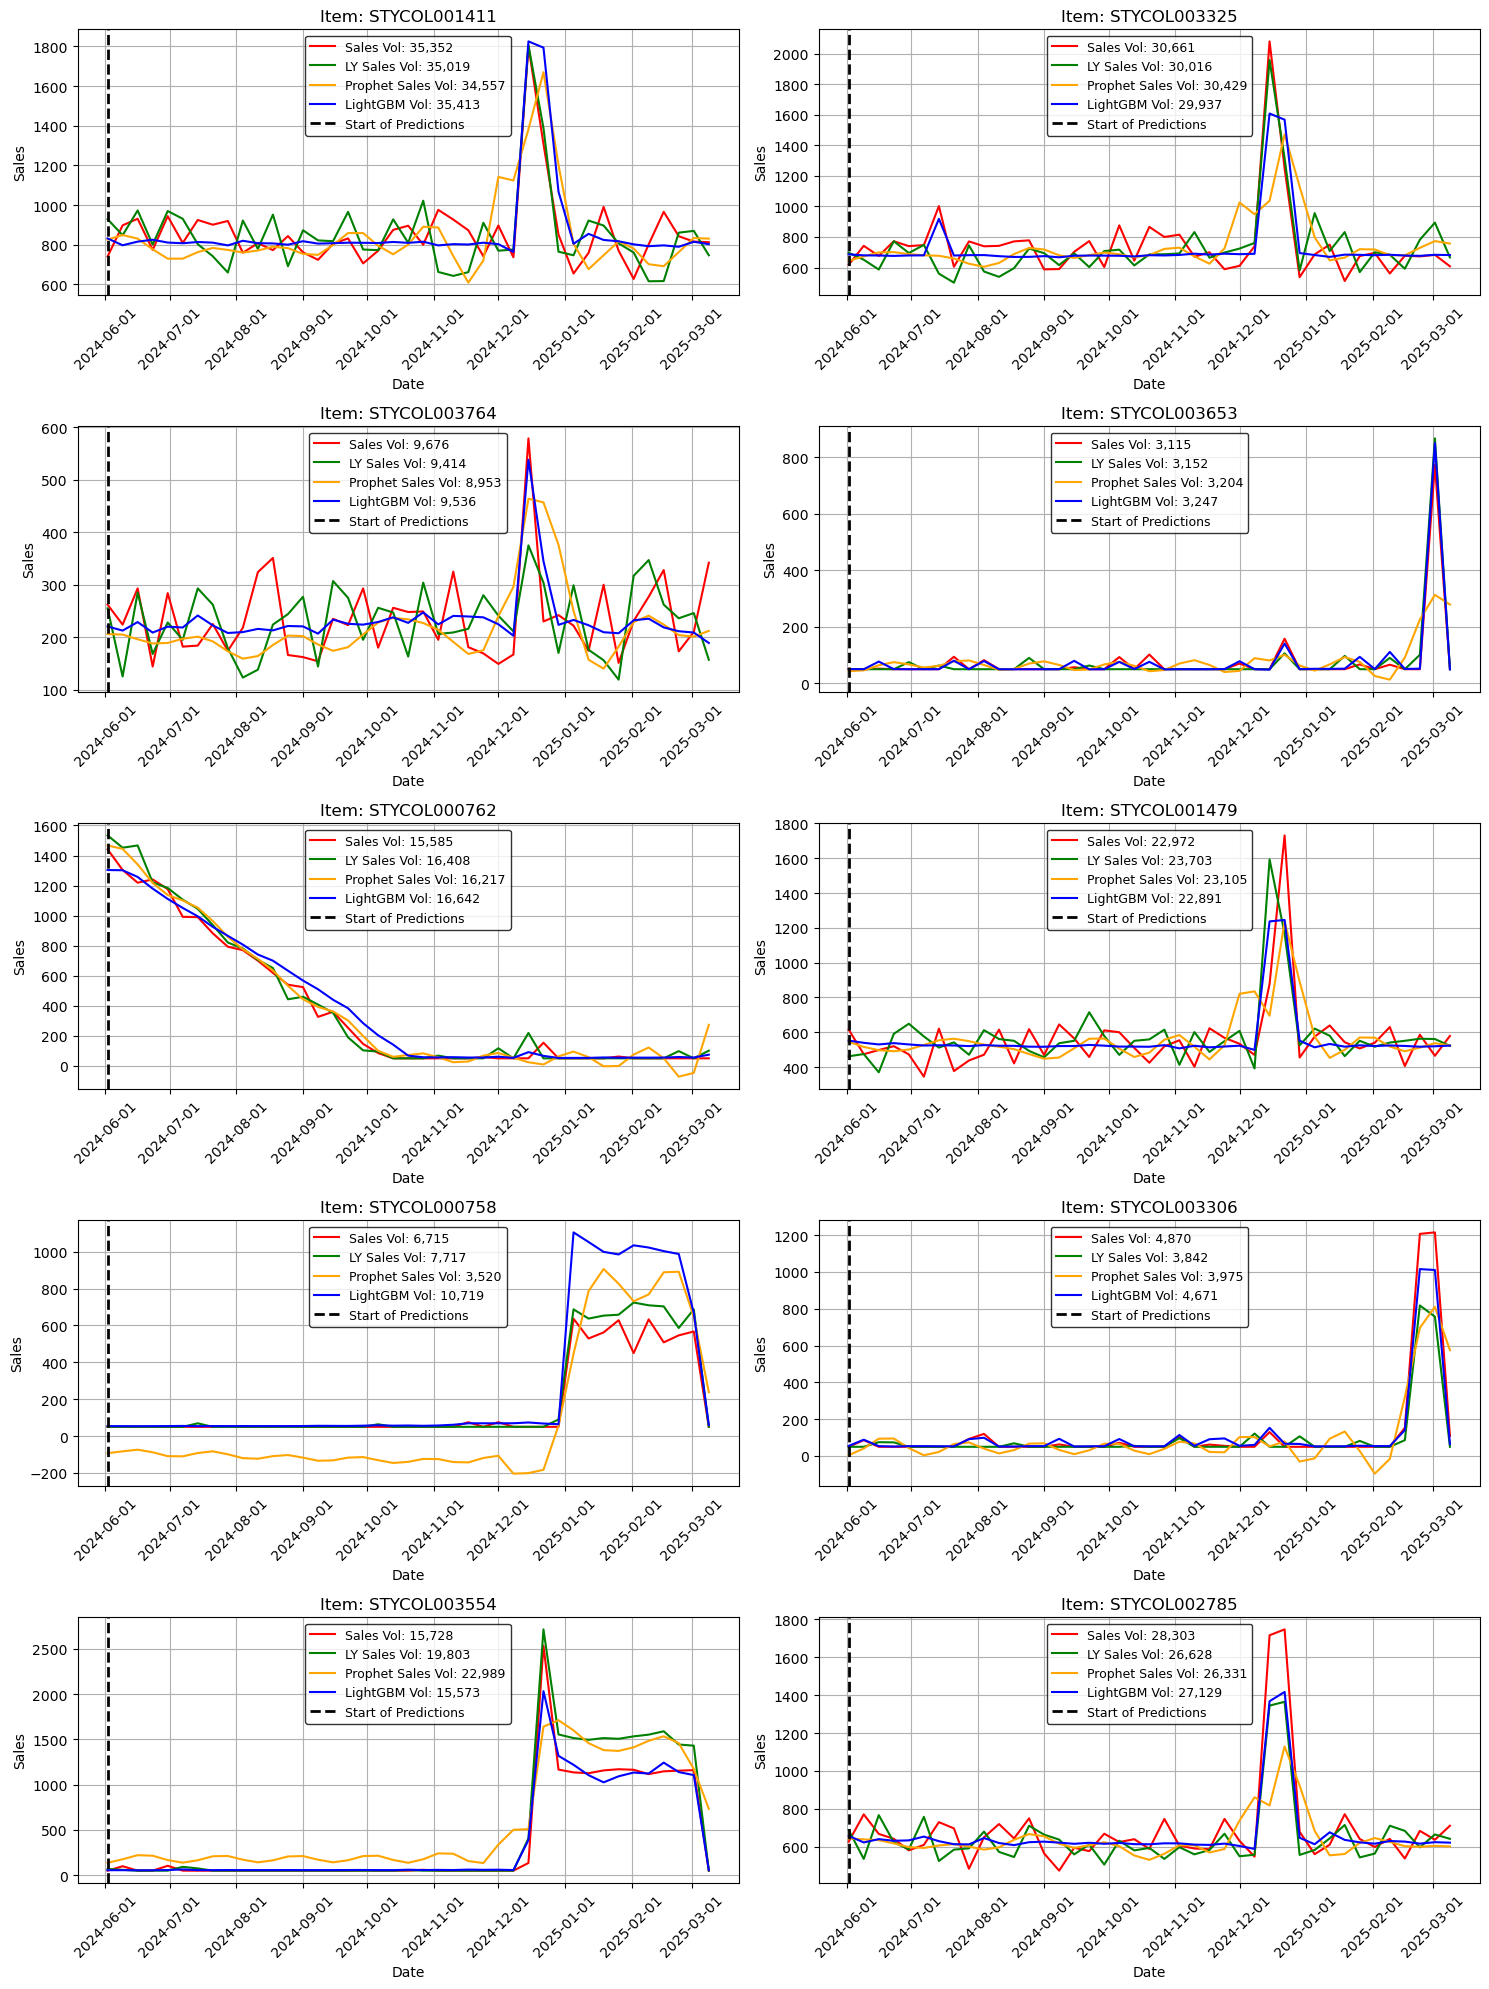

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Load the predictions CSV file
file_path = "/home/py/data/LGBM_ONLINE_v1/data/processed/merged.csv"
df = pd.read_csv(file_path)

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data for the specified epoch_week range
filtered_df = df[(df['epoch_week'].between(epoch_test_start, epoch_test_end))]

# Calculate total sales for each item within the specified range
item_sales = filtered_df.groupby('item_id')['sales'].sum().sort_values(ascending=False)

# Select the top 10 items based on sales
items = item_sales.sample(n=10, random_state=23).index.tolist()

# Set up the figure and axes
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))  # Adjust grid layout
axes = axes.flatten()  # Flatten axes for easier indexing

# Loop through each item and create a plot
for i, item in enumerate(items):
    ax = axes[i]

    # Filter data for the current item
    item_data = filtered_df[filtered_df['item_id'] == item]

    # Filter data only for relevant weeks
    filtered_data = filtered_df[filtered_df['epoch_week'] >= epoch_test_start].copy()

    # Fill NaN values to avoid miscalculations
    filtered_data = filtered_data.fillna(0)

    # Compute AUC for actual sales
    actual_sales_volume = filtered_data[filtered_data['item_id'] == item]['sales'].sum()

    # Compute AUC for LY
    ly_sales_volume = filtered_data[filtered_data['item_id'] == item]['ly'].sum()

    # Compute AUC for LY
    yhat_sales_volume = filtered_data[filtered_data['item_id'] == item]['yhat'].sum()
    
    # List of other prediction columns
    prediction_columns = [
        'predict_avg_sales',
        'predict_all_sales',
        'predict_cluster_kmeans_fs_sales',
        'predict_cluster_hac_s_sales',
        'predict_cluster_seasonal_fs_sales'
    ]

    # Compute AUC for each prediction
    auc_values = {}  
    for col in prediction_columns:
        pred_volume = filtered_data[filtered_data['item_id'] == item][col].sum()
        auc_values[col] = pred_volume  # Store AUC for each prediction

    # Find the prediction column with the closest AUC to sales
    best_prediction = min(auc_values, key=lambda k: abs(auc_values[k] - actual_sales_volume))
    best_prediction_auc = int(auc_values[best_prediction])  # AUC for the best prediction
   
    cleaned_prediction = (
        best_prediction.replace("predict_cluster_","")
            .replace("predict_","")
            .replace("_sales","")
            .replace("_"," ")
            .title()
    )

    # Define formatted legend labels with AUC values
    sales_label = f"Sales Vol: {actual_sales_volume:,.0f}"
    ly_label = f"LY Sales Vol: {ly_sales_volume:,.0f}"
    yhat_label = f"Prophet Sales Vol: {yhat_sales_volume:,.0f}"
    # best_pred_label = f"{cleaned_prediction} Vol: {best_prediction_auc:,.0f}"
    best_pred_label = f"LightGBM Vol: {best_prediction_auc:,.0f}"

    # Plot sales and LY
    ax.plot(item_data['date'], item_data['sales'], label=sales_label, linestyle='-', color='red')
    ax.plot(item_data['date'], item_data['ly'], label=ly_label, linestyle='-', color='green')
    ax.plot(item_data['date'], item_data['yhat'], label=yhat_label, linestyle='-', color='orange')

    # Plot the best matching prediction
    # ax.plot(item_data['date'], item_data[best_prediction], label=best_pred_label, linestyle='-', color='blue')
    ax.plot(item_data['date'], item_data[best_prediction], label=best_pred_label, linestyle='-', color='blue')

    # Customize the plot
    ax.set_title(f"Item: {item}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend(loc='lower left')  # Move legend to upper right
    ax.grid(True)
    
    # Draw a vertical line at the target date
    ax.axvline(target_date, color='black', linestyle='--', linewidth=2, label="Start of Predictions")

    # Move the legend to the upper left to replace the text box loc='upper left'
    ax.legend(loc='upper center', fontsize=9, frameon=True, facecolor='white', edgecolor='black')

# Adjust layout
for ax in axes:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjust tick locations
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format as "YYYY-MM-DD"
    ax.tick_params(axis='x', rotation=45)  # Rotate labels 45 degrees for better readability
    
plt.tight_layout()
plt.savefig('random.png', dpi=300)  # Specify the path and file name here
plt.show()


In [28]:
print(item_data.head())


         date       item_id  sales  epoch_week  woy  moy  qoy  soy  year  \
6  2023-05-28  STYCOL002796    585        2786   21    5    2    1  2023   
16 2023-06-04  STYCOL002796    503        2787   22    6    2    1  2023   
26 2023-06-11  STYCOL002796    475        2788   23    6    2    1  2023   
36 2023-06-18  STYCOL002796    389        2789   24    6    2    1  2023   
46 2023-06-25  STYCOL002796    521        2790   25    6    2    1  2023   

    epoch_week_sin  ...  roll_min_4  roll_max_13  roll_min_13  roll_max_52  \
6        -0.464723  ...         NaN          NaN          NaN          NaN   
16       -0.568065  ...         NaN          NaN          NaN          NaN   
26       -0.663123  ...         NaN          NaN          NaN          NaN   
36       -0.748511  ...         NaN          NaN          NaN          NaN   
46       -0.822984  ...         NaN          NaN          NaN          NaN   

    roll_min_52  predict_cluster_hac_s_sales  \
6           NaN           

In [22]:
print(items.tolist())

['ITEM_000459', 'ITEM_005241', 'ITEM_007672', 'ITEM_006367', 'ITEM_003193', 'ITEM_006294', 'ITEM_005257', 'ITEM_001092', 'ITEM_008137', 'ITEM_007234']


Create a csv of all items and the predictions

In [63]:
import pandas as pd

# Load the predictions CSV file
file_path = "/home/py/data/LGBM_ITEM_v1/data/processed/predictions.csv"
df = pd.read_csv(file_path)
epoch_test_start = 2168

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Get the list of all valid items that have at least 25 sales values in the specified epoch range
valid_items = (
    df[(df['epoch_week'].between(epoch_test_start, epoch_test_end))]
    .groupby('item_id')['sales']
    .count()
    .loc[lambda x: x >= 25]
    .index
)

# Initialize a list to store AUC comparison data
auc_comparison = []

# List of prediction columns
prediction_columns = [
    'predict_avg_sales',
    'predict_all_sales',
    'predict_cluster_kmeans_fs_sales',
    'predict_cluster_hac_s_sales',
    'predict_cluster_seasonal_fs_sales'
]

# Process all valid items
for item in valid_items:
    # Filter data only for relevant weeks for the current item
    filtered_data = df[(df['epoch_week'] >= epoch_test_start) & (df['item_id'] == item)].copy()

    # Fill NaN values to avoid miscalculations
    filtered_data = filtered_data.fillna(0)

    # Compute AUC for actual sales
    actual_sales_volume = filtered_data['sales'].sum()

    # Compute AUC for LY (Last Year)
    ly_sales_volume = filtered_data['ly'].sum()

    # Compute AUC for each prediction method
    auc_values = {col: filtered_data[col].sum() for col in prediction_columns}

    # Identify the best prediction method (closest AUC to actual sales)
    best_prediction = min(auc_values, key=lambda k: abs(auc_values[k] - actual_sales_volume))
    best_prediction_auc = int(auc_values[best_prediction])  # AUC for the best prediction

    # Clean up the best prediction method name
    cleaned_prediction = (
        best_prediction.replace("predict_cluster_", "")
                      .replace("predict_", "")
                      .replace("_sales", "")
                      .replace("_", " ")
                      .title()
    )

    # Calculate differences
    diff_sales_best = abs(actual_sales_volume - best_prediction_auc)
    diff_sales_ly = abs(actual_sales_volume - ly_sales_volume)

    # Append data to list
    auc_comparison.append([
        item, actual_sales_volume, cleaned_prediction, best_prediction_auc, ly_sales_volume, diff_sales_best, diff_sales_ly
    ])

# Save AUC comparison data to CSV
auc_df = pd.DataFrame(auc_comparison, columns=[
    'Item', 'Sales AUC', 'Best Prediction Method', 'Best Prediction AUC', 'LY AUC', 'Diff Sales-Best', 'Diff Sales-LY'
])
auc_df.to_csv("auc_comparison.csv", index=False)

print("AUC comparison saved to auc_comparison.csv")


AUC comparison saved to auc_comparison.csv


## View high volume items...

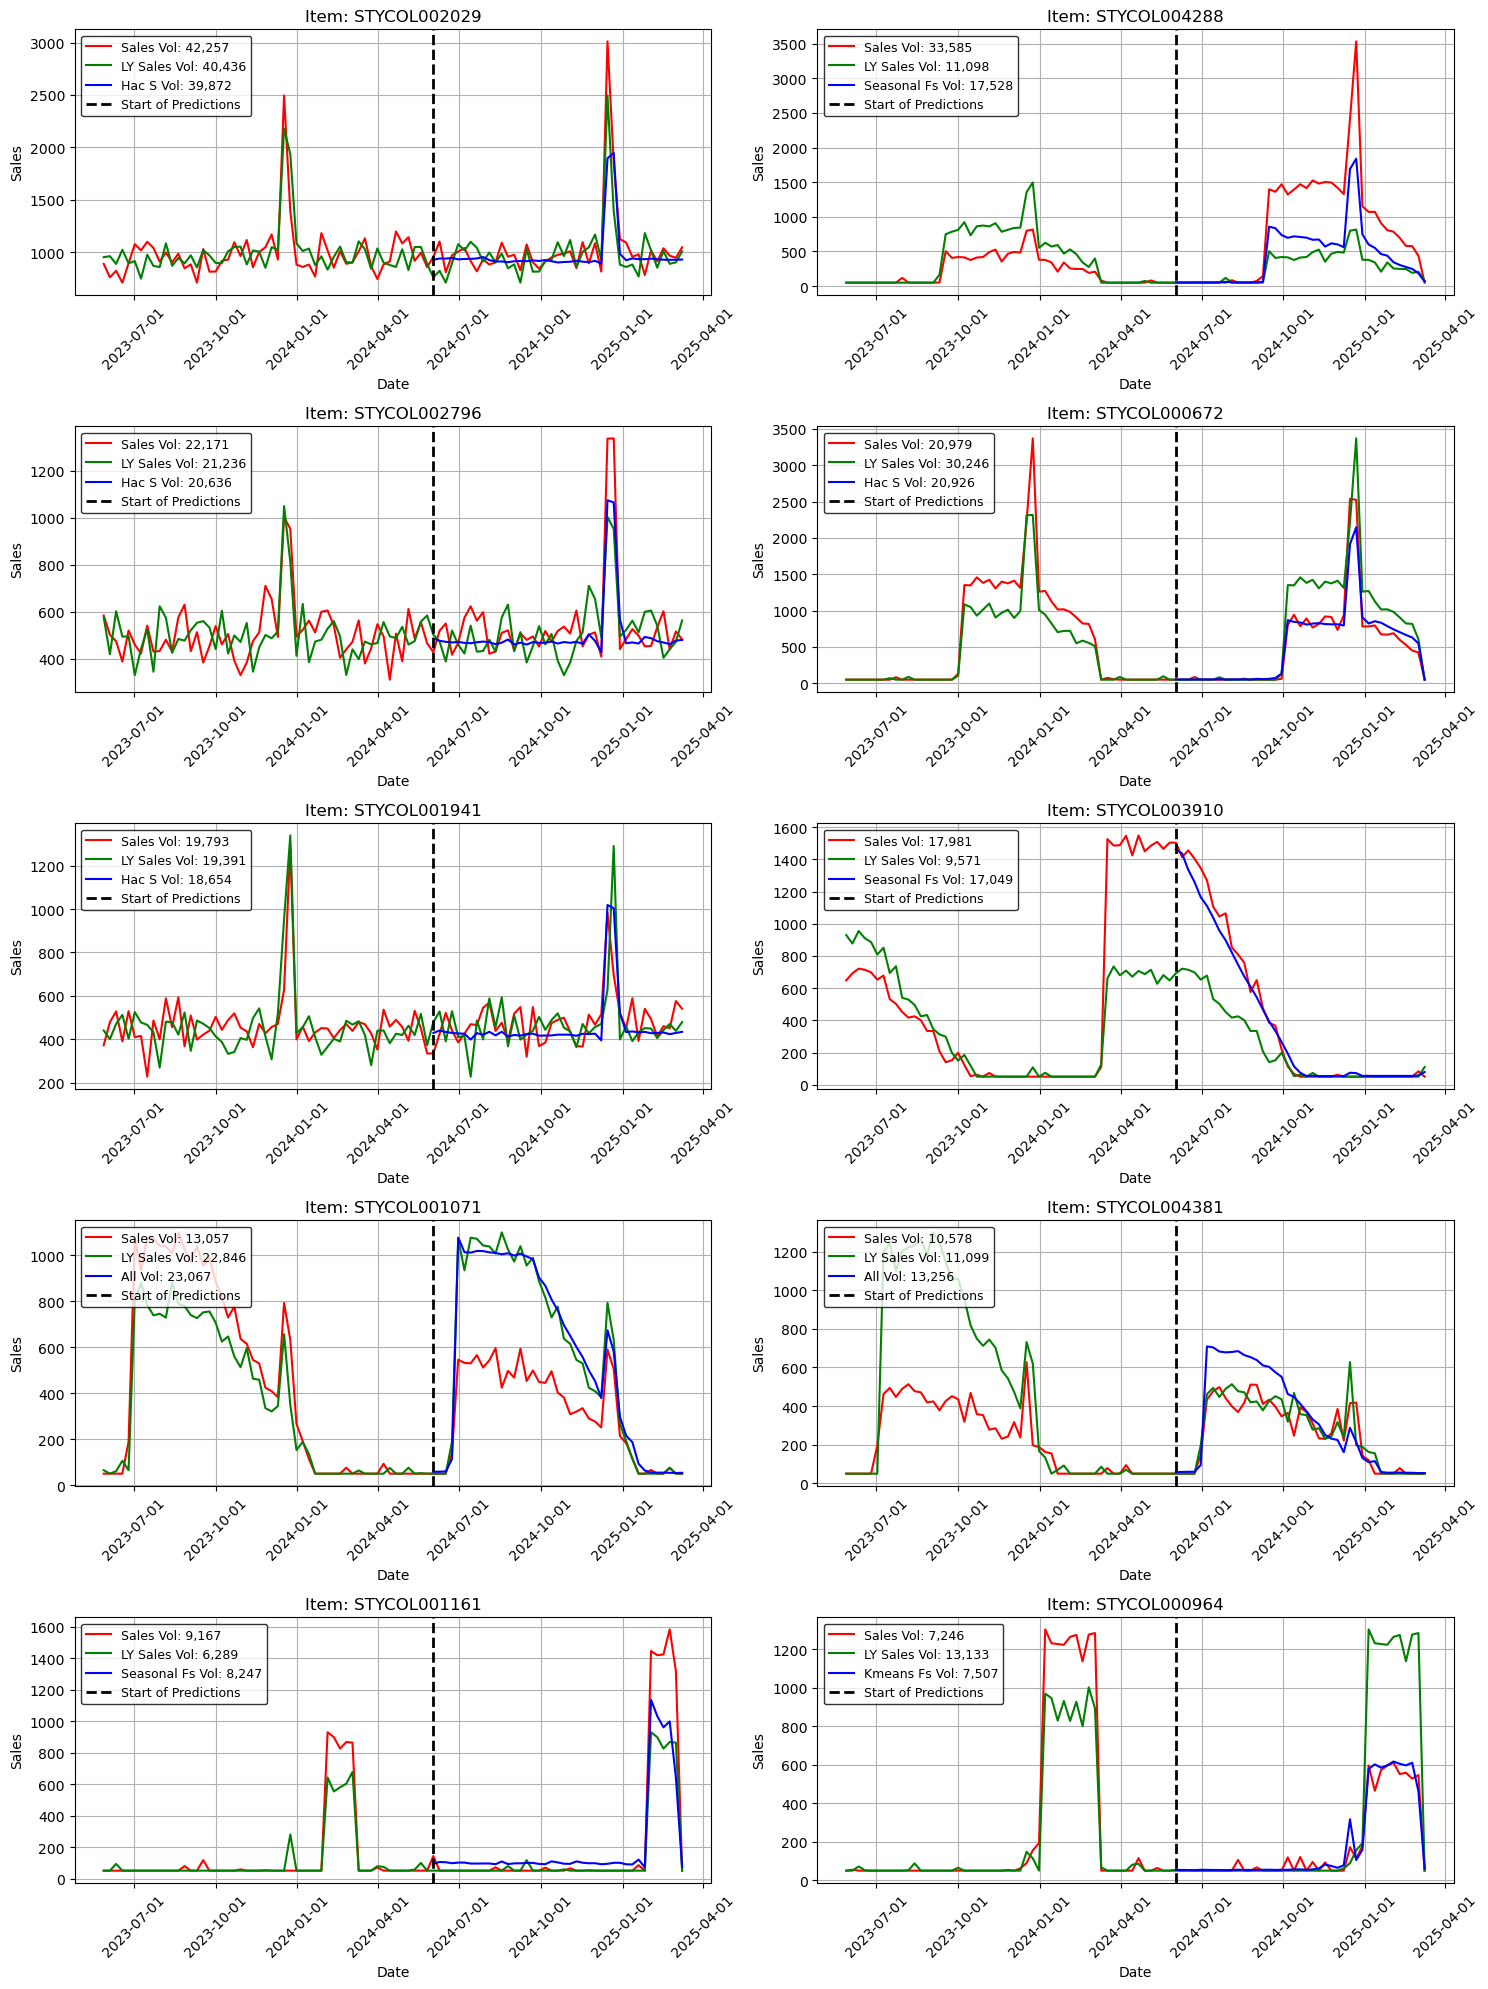

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Load the predictions CSV file
file_path = "/home/py/data/LGBM_ONLINE_v1/data/processed/predictions.csv"
df = pd.read_csv(file_path)

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data for the specified epoch_week range
filtered_df = df[(df['epoch_week'].between(epoch_test_start, epoch_test_end))]

# Calculate total sales for each item within the specified range
item_sales = filtered_df.groupby('item_id')['sales'].sum().sort_values(ascending=False)

# Select the top 10 items based on sales
items = item_sales.head(10).index.tolist()

# Set up the figure and axes
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))  # Adjust grid layout
axes = axes.flatten()  # Flatten axes for easier indexing

# Loop through each item and create a plot
for i, item in enumerate(items):
    ax = axes[i]

    # Filter data for the current item
    item_data = df[df['item_id'] == item]

    # Filter data only for relevant weeks
    filtered_data = df[df['epoch_week'] >= epoch_test_start].copy()

    # Fill NaN values to avoid miscalculations
    filtered_data = filtered_data.fillna(0)

    # Compute AUC for actual sales
    actual_sales_volume = filtered_data[filtered_data['item_id'] == item]['sales'].sum()

    # Compute AUC for LY
    ly_sales_volume = filtered_data[filtered_data['item_id'] == item]['ly'].sum()

    # List of other prediction columns
    prediction_columns = [
        'predict_avg_sales',
        'predict_all_sales',
        'predict_cluster_kmeans_fs_sales',
        'predict_cluster_hac_s_sales',
        'predict_cluster_seasonal_fs_sales'
    ]

    # Compute AUC for each prediction
    auc_values = {}  
    for col in prediction_columns:
        pred_volume = filtered_data[filtered_data['item_id'] == item][col].sum()
        auc_values[col] = pred_volume  # Store AUC for each prediction

    # Find the prediction column with the closest AUC to sales
    best_prediction = min(auc_values, key=lambda k: abs(auc_values[k] - actual_sales_volume))
    best_prediction_auc = int(auc_values[best_prediction])  # AUC for the best prediction
   
    cleaned_prediction = (
        best_prediction.replace("predict_cluster_","")
            .replace("predict_","")
            .replace("_sales","")
            .replace("_"," ")
            .title()
    )

    # Define formatted legend labels with AUC values
    sales_label = f"Sales Vol: {actual_sales_volume:,.0f}"
    ly_label = f"LY Sales Vol: {ly_sales_volume:,.0f}"
    best_pred_label = f"{cleaned_prediction} Vol: {best_prediction_auc:,.0f}"

    # Plot sales and LY
    ax.plot(item_data['date'], item_data['sales'], label=sales_label, linestyle='-', color='red')
    ax.plot(item_data['date'], item_data['ly'], label=ly_label, linestyle='-', color='green')

    # Plot the best matching prediction
    ax.plot(item_data['date'], item_data[best_prediction], label=best_pred_label, linestyle='-', color='blue')

    # Customize the plot
    ax.set_title(f"Item: {item}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend(loc='lower left')  # Move legend to upper right
    ax.grid(True)
    
    # Draw a vertical line at the target date
    ax.axvline(target_date, color='black', linestyle='--', linewidth=2, label="Start of Predictions")

    # Move the legend to the upper left to replace the text box
    ax.legend(loc='upper left', fontsize=9, frameon=True, facecolor='white', edgecolor='black')

# Adjust layout
for ax in axes:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjust tick locations
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format as "YYYY-MM-DD"
    ax.tick_params(axis='x', rotation=45)  # Rotate labels 45 degrees for better readability
    
plt.tight_layout()
plt.show()


# Review the top 10 predictions where LY beat Predicitions the most

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Load the predictions CSV file
file_path = "/home/py/data/LGBM_ITEM_v1/data/processed/predictions.csv"
df = pd.read_csv(file_path)


# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data only for relevant weeks
filtered_data = df[df['epoch_week'] >= epoch_test_start].copy()

# Fill NaN values to avoid miscalculations
filtered_data = filtered_data.fillna(0)

# Compute AUC for each item
auc_results = []
prediction_columns = [
    'predict_avg_sales',
    'predict_all_sales',
    'predict_cluster_kmeans_fs_sales',
    'predict_cluster_hac_s_sales',
    'predict_cluster_seasonal_fs_sales'
]

for item in filtered_data['item_id'].unique():
    item_data = filtered_data[filtered_data['item_id'] == item]

    actual_sales_auc = item_data['sales'].sum()
    ly_sales_auc = item_data['ly'].sum()

    # Compute AUC for each prediction
    auc_values = {col: item_data[col].sum() for col in prediction_columns}

    # Find the best prediction (closest to actual sales)
    best_prediction = min(auc_values, key=lambda k: abs(auc_values[k] - actual_sales_auc))
    best_prediction_auc = auc_values[best_prediction]

    # Store results
    auc_results.append({
        "item_id": item,
        "sales_auc": actual_sales_auc,
        "ly_auc": ly_sales_auc,
        "best_pred_auc": best_prediction_auc,
        "best_prediction": best_prediction,
        "sales_vs_ly_diff": abs(actual_sales_auc - ly_sales_auc),
        "sales_vs_best_diff": abs(actual_sales_auc - best_prediction_auc)
    })

# Convert to DataFrame
auc_df = pd.DataFrame(auc_results)

# Step 1: Filter items where abs(sales AUC - LY AUC) < abs(sales AUC - best prediction)
filtered_auc_df = auc_df[auc_df["sales_vs_ly_diff"] < auc_df["sales_vs_best_diff"]]

# Step 2: Select the top 10 items with the highest abs(sales AUC - best prediction)
top_items = filtered_auc_df.nlargest(10, "sales_vs_best_diff")

# Set up the figure and axes
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))  # Adjust grid layout
axes = axes.flatten()  # Flatten axes for easier indexing

# Ensure `top_items` is properly indexed from 0
top_items = top_items.reset_index(drop=True)

# Loop through each item and create a plot
for i, row in top_items.iterrows():
    item = row["item_id"]
    ax = axes[i]

    # Filter data for the current item
    item_data = df[df['item_id'] == item]

    # Define formatted legend labels with AUC values
    sales_label = f"Sales Vol: {row['sales_auc']:,.0f}"
    ly_label = f"LY Sales Vol: {row['ly_auc']:,.0f}"
    best_pred_label = f"{row['best_prediction'].replace('predict_', '').replace('_sales', '').title()} Vol: {row['best_pred_auc']:,.0f}"

    # Plot sales and LY
    ax.plot(item_data['date'], item_data['sales'], label=sales_label, linestyle='-', color='red')
    ax.plot(item_data['date'], item_data['ly'], label=ly_label, linestyle='-', color='green')

    # Plot the best matching prediction
    ax.plot(item_data['date'], item_data[row["best_prediction"]], label=best_pred_label, linestyle='-', color='blue')

    # Customize the plot
    ax.set_title(f"Item: {item}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend(loc='upper left', fontsize=9, frameon=True, facecolor='white', edgecolor='black')
    ax.grid(True)

    # Draw a vertical line at the start of predictions
    # target_date = pd.to_datetime("2011-07-24")
    ax.axvline(target_date, color='black', linestyle='--', linewidth=2, label="Start of Predictions")

# Adjust layout
for ax in axes:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjust tick locations
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format as "YYYY-MM-DD"
    ax.tick_params(axis='x', rotation=45)  # Rotate labels 45 degrees for better readability

plt.tight_layout()
plt.show()


KeyError: 'sales_vs_ly_diff'

In [42]:
print(top_items['item_id'].tolist())

['ITEM_001664', 'ITEM_001608', 'ITEM_001617', 'ITEM_001529', 'ITEM_001670', 'ITEM_001533', 'ITEM_001851', 'ITEM_001853', 'ITEM_001646', 'ITEM_001609']


# Review the top 10 predictions where Predications beat LY the most 

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Load the predictions CSV file
file_path = "/home/py/data/LGBM_ITEM_v1/data/processed/predictions.csv"
df = pd.read_csv(file_path)

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data only for relevant weeks
filtered_data = df[df['epoch_week'] >= epoch_test_start].copy()

# Fill NaN values to avoid miscalculations
filtered_data = filtered_data.fillna(0)

# Compute AUC for each item
auc_results = []
prediction_columns = [
    'predict_avg_sales',
    'predict_all_sales',
    'predict_cluster_kmeans_fs_sales',
    'predict_cluster_hac_s_sales',
    'predict_cluster_seasonal_fs_sales'
]

for item in filtered_data['item_id'].unique():
    item_data = filtered_data[filtered_data['item_id'] == item]

    actual_sales_auc = item_data['sales'].sum()
    ly_sales_auc = item_data['ly'].sum()

    # Compute AUC for each prediction
    auc_values = {col: item_data[col].sum() for col in prediction_columns}

    # Find the best prediction (closest to actual sales)
    best_prediction = min(auc_values, key=lambda k: abs(auc_values[k] - actual_sales_auc))
    best_prediction_auc = auc_values[best_prediction]

    # Store results
    auc_results.append({
        "item_id": item,
        "sales_auc": actual_sales_auc,
        "ly_auc": ly_sales_auc,
        "best_pred_auc": best_prediction_auc,
        "best_prediction": best_prediction,
        "sales_vs_ly_diff": abs(actual_sales_auc - ly_sales_auc),
        "sales_vs_best_diff": abs(actual_sales_auc - best_prediction_auc)
    })

# Convert to DataFrame
auc_df = pd.DataFrame(auc_results)

# Step 1: Filter items where abs(sales AUC - LY AUC) < abs(sales AUC - best prediction)
filtered_auc_df = auc_df[auc_df["sales_vs_ly_diff"] > auc_df["sales_vs_best_diff"]]

# Step 2: Select the top 10 items with the highest abs(sales AUC - best prediction)
top_items = filtered_auc_df.nlargest(10, "sales_vs_best_diff")

# Set up the figure and axes
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))  # Adjust grid layout
axes = axes.flatten()  # Flatten axes for easier indexing

# Ensure `top_items` is properly indexed from 0
top_items = top_items.reset_index(drop=True)

# Loop through each item and create a plot
for i, row in top_items.iterrows():
    item = row["item_id"]
    ax = axes[i]

    # Filter data for the current item
    item_data = df[df['item_id'] == item]

    # Define formatted legend labels with AUC values
    sales_label = f"Sales Vol: {row['sales_auc']:,.0f}"
    ly_label = f"LY Sales Vol: {row['ly_auc']:,.0f}"
    best_pred_label = f"{row['best_prediction'].replace('predict_', '').replace('_sales', '').title()} Vol: {row['best_pred_auc']:,.0f}"

    # Plot sales and LY
    ax.plot(item_data['date'], item_data['sales'], label=sales_label, linestyle='-', color='red')
    ax.plot(item_data['date'], item_data['ly'], label=ly_label, linestyle='-', color='green')

    # Plot the best matching prediction
    ax.plot(item_data['date'], item_data[row["best_prediction"]], label=best_pred_label, linestyle='-', color='blue')

    # Customize the plot
    ax.set_title(f"Item: {item}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend(loc='upper left', fontsize=9, frameon=True, facecolor='white', edgecolor='black')
    ax.grid(True)

    # Draw a vertical line at the start of predictions
    # target_date = pd.to_datetime("2011-07-24")
    ax.axvline(target_date, color='black', linestyle='--', linewidth=2, label="Start of Predictions")

# Adjust layout
for ax in axes:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjust tick locations
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format as "YYYY-MM-DD"
    ax.tick_params(axis='x', rotation=45)  # Rotate labels 45 degrees for better readability

plt.tight_layout()
plt.savefig('random.png', dpi=300)  # Specify the path and file name here
plt.show()


KeyError: 'sales_vs_ly_diff'

In [73]:
print(filtered_df.shape)
print(epoch_test_start)
print(epoch_test_end)

(0, 53)
2839
2879


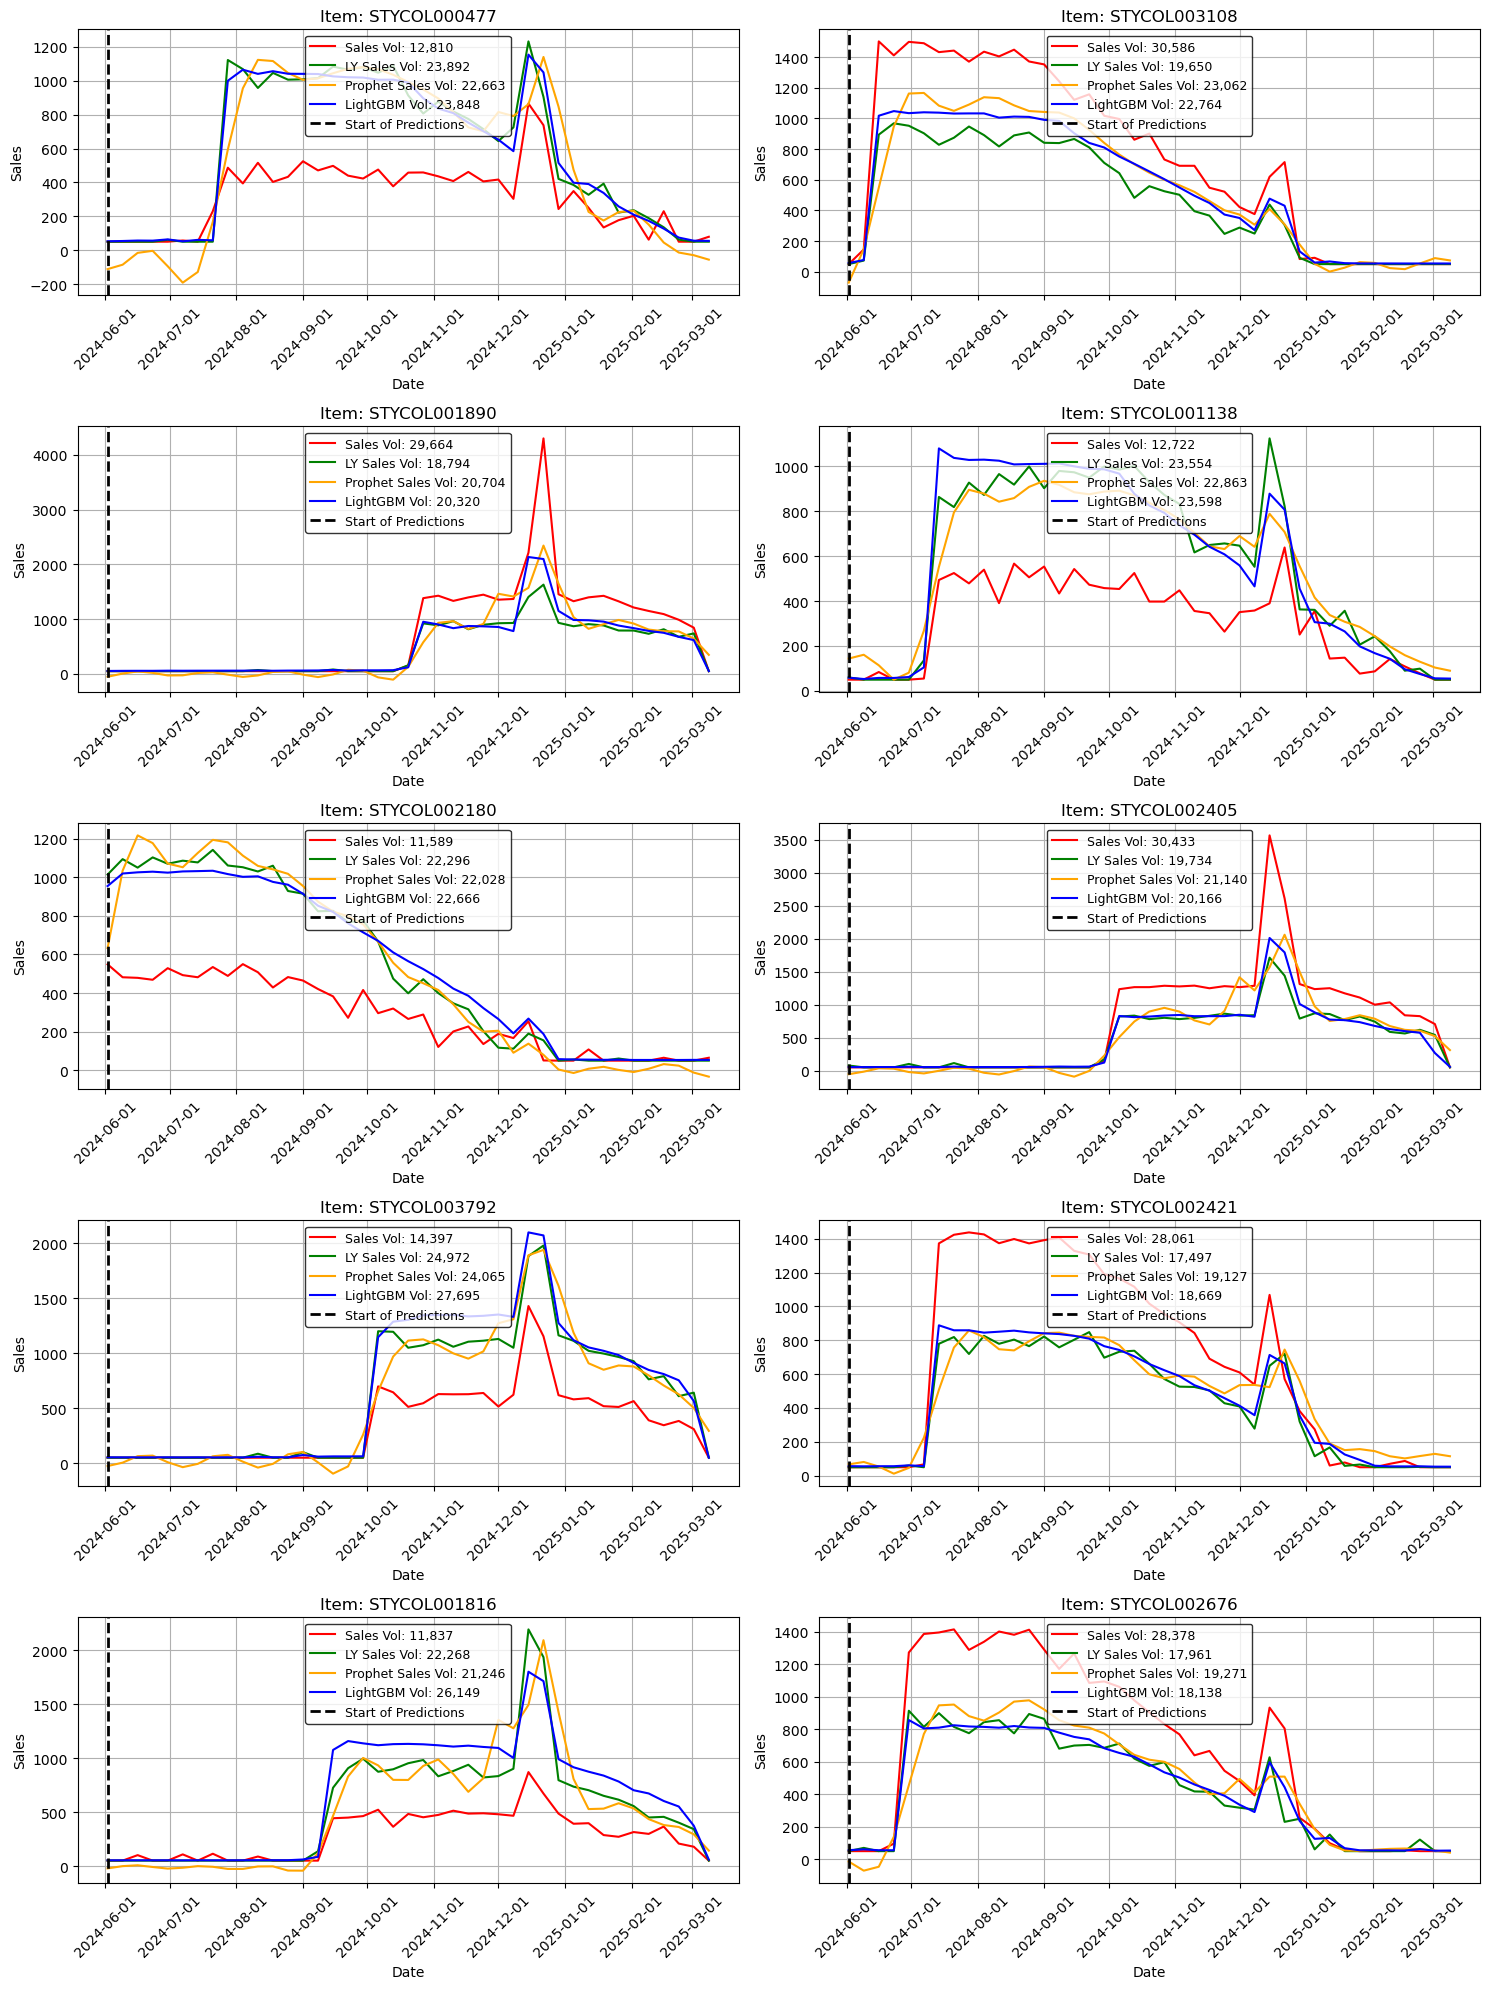

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# epoch_test_start = 2839
# epoch_test_end = 2879
# target_date = pd.to_datetime("2024-06-02")
# epoch_test_ly = 2786

# Load the predictions CSV file
file_path = "/home/py/data/LGBM_ONLINE_v1/data/processed/merged.csv"
df = pd.read_csv(file_path)

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data for the specified epoch_week range
filtered_df = df[(df['epoch_week'].between(epoch_test_start, epoch_test_end))]

# Calculate total sales for each item within the specified range
item_sales = filtered_df.groupby('item_id')['sales'].sum().sort_values(ascending=False)

# Select the top 10 items based on sales
items = item_sales.sample(n=10, random_state=44).index.tolist()
items = ['STYCOL000004','STYCOL000010','STYCOL000016','STYCOL000025','STYCOL000031',
         'STYCOL000032','STYCOL000033','STYCOL000041','STYCOL000043','STYCOL000052']
items = ['STYCOL000056','STYCOL000057','STYCOL000058','STYCOL000062','STYCOL000065',
         'STYCOL000069','STYCOL000083','STYCOL000085''STYCOL000086','STYCOL000096']
items = ['STYCOL000602','STYCOL000610','STYCOL000612','STYCOL000613','STYCOL000614',
         'STYCOL000617','STYCOL000618','STYCOL000622','STYCOL000630','STYCOL000635']
items = ["STYCOL003981","STYCOL002494","STYCOL002180","STYCOL001138","STYCOL000477",
         "STYCOL003016","STYCOL003792","STYCOL001816","STYCOL003301","STYCOL004574"]
items = [
    "STYCOL002405", "STYCOL001306", "STYCOL000812", "STYCOL002676", "STYCOL001890",
    "STYCOL002421", "STYCOL003389", "STYCOL004147", "STYCOL003984", "STYCOL003795"
]
items = [
    "STYCOL000477", "STYCOL003108", "STYCOL001890", "STYCOL001138", "STYCOL002180",
    "STYCOL002405", "STYCOL003792", "STYCOL002421", "STYCOL001816", "STYCOL002676"
]

# Set up the figure and axes
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))  # Adjust grid layout
axes = axes.flatten()  # Flatten axes for easier indexing

# Loop through each item and create a plot
for i, item in enumerate(items):
    ax = axes[i]

    # Filter data for the current item
    item_data = filtered_df[filtered_df['item_id'] == item]

    # Filter data only for relevant weeks
    filtered_data = filtered_df[filtered_df['epoch_week'] >= epoch_test_start].copy()

    # Fill NaN values to avoid miscalculations
    filtered_data = filtered_data.fillna(0)

    # Compute AUC for actual sales
    actual_sales_volume = filtered_data[filtered_data['item_id'] == item]['sales'].sum()

    # Compute AUC for LY
    ly_sales_volume = filtered_data[filtered_data['item_id'] == item]['ly'].sum()

    # Compute AUC for LY
    yhat_sales_volume = filtered_data[filtered_data['item_id'] == item]['yhat'].sum()
    
    # List of other prediction columns
    prediction_columns = [
        'predict_avg_sales',
        'predict_all_sales',
        'predict_cluster_kmeans_fs_sales',
        'predict_cluster_hac_s_sales',
        'predict_cluster_seasonal_fs_sales'
    ]

    # Compute AUC for each prediction
    auc_values = {}  
    for col in prediction_columns:
        pred_volume = filtered_data[filtered_data['item_id'] == item][col].sum()
        auc_values[col] = pred_volume  # Store AUC for each prediction

    # Find the prediction column with the closest AUC to sales
    best_prediction = min(auc_values, key=lambda k: abs(auc_values[k] - actual_sales_volume))
    best_prediction_auc = int(auc_values[best_prediction])  # AUC for the best prediction
   
    cleaned_prediction = (
        best_prediction.replace("predict_cluster_","")
            .replace("predict_","")
            .replace("_sales","")
            .replace("_"," ")
            .title()
    )

    # Define formatted legend labels with AUC values
    sales_label = f"Sales Vol: {actual_sales_volume:,.0f}"
    ly_label = f"LY Sales Vol: {ly_sales_volume:,.0f}"
    yhat_label = f"Prophet Sales Vol: {yhat_sales_volume:,.0f}"
    # best_pred_label = f"{cleaned_prediction} Vol: {best_prediction_auc:,.0f}"
    best_pred_label = f"LightGBM Vol: {best_prediction_auc:,.0f}"

    # Plot sales and LY
    ax.plot(item_data['date'], item_data['sales'], label=sales_label, linestyle='-', color='red')
    ax.plot(item_data['date'], item_data['ly'], label=ly_label, linestyle='-', color='green')
    ax.plot(item_data['date'], item_data['yhat'], label=yhat_label, linestyle='-', color='orange')

    # Plot the best matching prediction
    # ax.plot(item_data['date'], item_data[best_prediction], label=best_pred_label, linestyle='-', color='blue')
    ax.plot(item_data['date'], item_data[best_prediction], label=best_pred_label, linestyle='-', color='blue')

    # Customize the plot
    ax.set_title(f"Item: {item}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend(loc='lower left')  # Move legend to upper right
    ax.grid(True)
    
    # Draw a vertical line at the target date
    ax.axvline(target_date, color='black', linestyle='--', linewidth=2, label="Start of Predictions")

    # Move the legend to the upper left to replace the text box loc='upper left'
    ax.legend(loc='upper center', fontsize=9, frameon=True, facecolor='white', edgecolor='black')

# Adjust layout
for ax in axes:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjust tick locations
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format as "YYYY-MM-DD"
    ax.tick_params(axis='x', rotation=45)  # Rotate labels 45 degrees for better readability
    
plt.tight_layout()
plt.savefig('random.png', dpi=300)  # Specify the path and file name here
plt.show()


In [67]:
print(filtered_df.shape)

(0, 53)
